In [4]:
pip install pandas


  Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl (11.5 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl.metadata (15 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl (11.1 MB)
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/41.0 MB ? eta -:--:--
    --------------------------------------- 0.5/41.0 MB 1.8 MB/s eta 0:00:23
    --------------------------------------- 0.8/41.0 MB 1.6 MB/s eta 0:00:26
    --------------------------------------- 0.8/41.0 MB 1.6 MB/s eta 0:00:26
    --------------------------------------- 0.8/41.0 MB 1.6 MB/s eta 0:00:26
    --------------------------------------- 0.8/41.0 MB 1.6 MB/s eta 0:00:26
    --------------------------------------- 0.8/41.0 MB 1.6 MB/s eta 0:00:26
    --------------------------------------- 0.8/41.0 MB 1.6 MB/s eta 0:00:26
    --------------------------------------- 0.8/41.0 MB 1.6 MB/s eta 0:00:26
    --------------------------


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import torch
from pathlib import Path
from transformers import DistilBertForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# path to your model folder and test CSV
MODEL_DIR = Path(r"C:\Users\Hp\Desktop\sentiment-analysis-app\sentiment_model")
TEST_CSV  = Path(r"C:\Users\Hp\Desktop\sentiment-analysis-app\test_data_for_evaluation.csv")


In [8]:
def load_model(model_dir: Path):

    model = DistilBertForSequenceClassification.from_pretrained(
        model_dir,
        local_files_only=True
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_dir,
        local_files_only=True
    )
    model.eval()
    return model, tokenizer

# sanity check
print("Model folder exists:", MODEL_DIR.exists())
model, tokenizer = load_model(MODEL_DIR)
print("Loaded model and tokenizer ✔️")


Model folder exists: True
Loaded model and tokenizer ✔️


In [9]:
def preprocess_df(csv_path: Path):
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=["text", "sentiment"])
    label_map = {"negative": 0, "neutral": 1, "positive": 2}
    df["label"] = df["sentiment"].str.lower().map(label_map)
    return df

df_test = preprocess_df(TEST_CSV)
print(df_test.head())


                                                text sentiment  label
0  WOOOOOOOOOO   are you coming to Nottingham at ...  positive      2
1                 resting had a whole day of walking   neutral      1
2  was in Palawan a couple of days ago, i`ll try ...   neutral      1
3  I know! I`m so slow its horrible. DON`T TELL O...  negative      0
4  Glad I went out, glad I didn`t leave early, an...  positive      2


In [10]:
@torch.no_grad()
def predict_batch(model, tokenizer, texts, device="cpu", batch_size=16):
    model.to(device)
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        out = model(**enc)
        batch_preds = torch.argmax(out.logits, dim=-1).cpu().tolist()
        preds.extend(batch_preds)
    return preds

# Quick smoke test on first 5 examples
sample_texts = df_test["text"].tolist()[:5]
print("Sample predictions:", predict_batch(model, tokenizer, sample_texts))


Sample predictions: [2, 1, 1, 0, 2]


In [11]:
y_true = df_test["label"].tolist()
y_pred = predict_batch(model, tokenizer, df_test["text"].tolist(),
                       device=("cuda" if torch.cuda.is_available() else "cpu"))

# 2) overall accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}\n")

# 3) classification report
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["negative", "neutral", "positive"],
    digits=4
))

# 4) confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Accuracy: 0.8520

Classification Report:
              precision    recall  f1-score   support

    negative     0.8762    0.8389    0.8571       422
     neutral     0.8183    0.8562    0.8368       626
    positive     0.8798    0.8584    0.8690       452

    accuracy                         0.8520      1500
   macro avg     0.8581    0.8512    0.8543      1500
weighted avg     0.8531    0.8520    0.8522      1500

Confusion Matrix:
[[354  59   9]
 [ 46 536  44]
 [  4  60 388]]


In [15]:
pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 2.1 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/8.1 MB 1.5 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 1.5 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/8.1 MB 1.5 MB/s eta 0:00:05
   ------- -------------------------------- 1.6/8.1 MB 1.4 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/8.1 MB 1.4 MB/s eta 0:00:05
   ---------- ----------------------------- 2.1/8.1 MB 1.4 MB/s eta 0:00:05
   ----------- ---------------------------- 2.4/8.1 MB 1.3 MB/s eta 0:00:05
   ------------ --------------------------- 2.6/8.1 MB 1.3 MB/s eta 0:00:05
   -------------- ------------------------- 2.9/8.1 MB 1.3 MB/s eta 0:00:04
   --------------- ------------------------ 3.1/8.1 MB 1.3 MB/s eta 0:00:04
   ------------------ ----


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


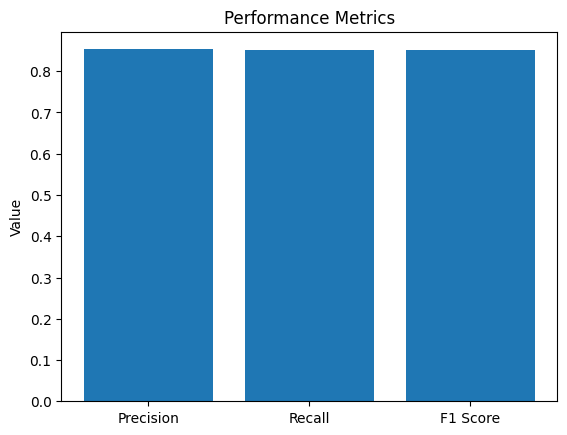

In [17]:
import matplotlib.pyplot as plt

# Bar plot for Precision, Recall, F1 Score
metrics = [precision, recall, f1_score]
labels = ['Precision', 'Recall', 'F1 Score']
plt.bar(labels, metrics)
plt.title("Performance Metrics")
plt.ylabel("Value")
plt.show()